In [43]:
from elections.DefaultConfigOptions import unit_election_config
from elections.Ballot import Ballot
from elections.ElectionConstructor import ElectionConstructor, construct_irv
from elections.Ideology import Ideology
from elections.PopulationGroup import Independents
from elections.Candidate import Candidate
from elections.NDPopulation import NDPopulation
from network import ElectionModel
from typing import List
from network.Tensor import Tensor
import numpy as np
import tensorflow as tf
import random
import math

n_bins = 21
max_ideology = 1.5
min_ideology = -1.5
ideology_range = max_ideology - min_ideology
ideology_dim = 1
ideology_zone = .6
n_voters = 100

In [44]:
def gen_random_candidates(population: NDPopulation, n: int)-> List[Candidate]:
    candidates = []
    while len(candidates) < n:
        ivec = population.unit_sample_voter().ideology.vec * .5
        if min_ideology < ivec[0] < max_ideology:
            candidates.append(Candidate(f"c-{len(candidates)}", Independents, Ideology(ivec), 0))

    return candidates

def convert_bin_to_ideology(bin: int) -> float:
    step = ideology_range / n_bins
    lower = bin * step + min_ideology
    upper = lower + step
    return random.uniform(lower, upper)

def convert_ideology_to_bin(ideology: float) -> int:
    ideology = max(min_ideology, min(ideology, max_ideology))
    pct = (ideology - min_ideology) / ideology_range
    return int(pct * n_bins)

def convert_candidates_to_input_vec( candidates: List[Candidate]) -> Tensor:
    cc = [convert_ideology_to_bin(c.ideology.vec[0]) for c in candidates]
    x = np.zeros(shape=(1, n_bins), dtype=np.single)
    for c in cc:
        x[0, c] = 1
    return x

def create_training_sample(candidates: List[Candidate], winner: Candidate) -> (int, list[int]):
    w = candidates.index(winner)
    cc = [convert_ideology_to_bin(c.ideology.vec[0]) for c in candidates]
    return cc, w

class ExtendedCandidate:
    def __init__(self, base_candidate: Candidate):
        self.base_candidate = base_candidate
        self.current_bin = convert_ideology_to_bin(base_candidate.ideology.vec[0])
        self.current_candidate = base_candidate

    def win_bonus(self, ideology: float) -> float:
        delta = math.fabs(ideology - self.base_candidate.ideology.vec[0])
        return max(1 - delta / ideology_zone, 0.0)

    def best_position(self, model: ElectionModel, other_candidates: List[Candidate], bin_range: int) -> float:
        x = convert_candidates_to_input_vec(other_candidates)
        win_probabilities = model(x).numpy()

        best_return = -1
        best_ideology = -1
        b_start = self.current_bin - bin_range
        b_end =  min(n_bins, self.current_bin + bin_range + 1)
        for b in range(b_start, b_end):
            ideology = convert_bin_to_ideology(b)
            if ideology >= max_ideology or convert_ideology_to_bin(ideology) >= n_bins:
                print(f"b: {b}, ideology {ideology:.6}")

            wb = self.win_bonus(ideology)
            expected_return = wb * win_probabilities[0, b]
            if expected_return > best_return:
                best_return = expected_return
                best_ideology = ideology

        return best_ideology

    def best_candidate(self, model: ElectionModel, all_candidates: List[Candidate], bin_range: int):
        other_candidates = list(filter(lambda c: c != self.current_candidate, all_candidates))
        assert(len(other_candidates) == 4)
        ideology = self.best_position(model, other_candidates, bin_range)
        self.current_bin = convert_ideology_to_bin(ideology)

        self.current_candidate = Candidate(
            self.base_candidate.name,
            self.base_candidate.party,
            Ideology(np.array([ideology])),
            self.base_candidate.quality)

        return self.current_candidate

def create_population() ->  NDPopulation:
    population_means = np.zeros(shape=(1,))
    population_stddev = np.ones(shape=(1,))
    return NDPopulation(population_means, population_stddev)

In [45]:
def run_sample_election( candidates: List[Candidate],
                         process: ElectionConstructor,
                         population: NDPopulation,
                         n_voters: int) -> Candidate:

    voters = population.generate_unit_voters(n_voters)
    ballots = [Ballot(v, candidates, unit_election_config) for v in voters]
    result = process.run(ballots, set(candidates))
    winner = result.winner()
    return winner

In [54]:
import matplotlib.pyplot as plt
def plot_results(results: List[List[float]], labels: List[str]):

    nrows = 1
    ncols = 1
    fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))
    fig.suptitle("Distance From Origin for Winner With Random Candidates", color="black", fontsize=22)
    fig.set_facecolor("white")

    count = 0

    axis.tick_params(axis='x', colors="black")
    axis.tick_params(axis='y', colors="black")
    # axis.set_xlim([0, 2])

    axis.hist(results, bins=30, label=labels)
    axis.legend()

    plt.savefig("foo.png")

In [53]:
def run_strategic_races():
    population = create_population()
    model = tf.keras.models.load_model("networks/net.2048.512.3.mdl")
    process = ElectionConstructor(construct_irv, "IRV")

    winners = []
    for i in range(1000):
        candidates = gen_random_candidates(population, 5)
        extended_candidates = [ExtendedCandidate(c) for c in candidates]
        for bb in [1, 2, 3]:
            cc = [ec.current_candidate for ec in extended_candidates]
            new_candidates = [e.best_candidate(model, cc, bb) for e in extended_candidates]
            candidates = new_candidates

        w = run_sample_election(candidates, process, population, 1000)
        print(f"{i:5d} w.ideology: {w.ideology.vec[0]:.4}")

        winners.append(w.ideology.vec[0])

In [57]:
winners = run_strategic_races()

    0 w.ideology: -0.4379
    1 w.ideology: 0.3459
    2 w.ideology: -0.137
    3 w.ideology: -0.4387
    4 w.ideology: -0.4344
    5 w.ideology: 0.0942
    6 w.ideology: 0.4715
    7 w.ideology: 0.527
    8 w.ideology: -0.2859
    9 w.ideology: -0.3933
   10 w.ideology: 0.0901
   11 w.ideology: -0.3995
   12 w.ideology: 0.4672
   13 w.ideology: 0.3189
   14 w.ideology: 0.5751
   15 w.ideology: -0.3081
   16 w.ideology: -0.3574
   17 w.ideology: -0.5575
   18 w.ideology: 0.4639
   19 w.ideology: 0.2601
   20 w.ideology: 0.308
   21 w.ideology: -0.5685
   22 w.ideology: 0.4767
   23 w.ideology: -0.2417
   24 w.ideology: -0.4391
   25 w.ideology: 0.4728
   26 w.ideology: -0.4888
   27 w.ideology: 0.2252
   28 w.ideology: -0.4777
   29 w.ideology: -0.1361
   30 w.ideology: -0.3594
   31 w.ideology: 0.4993
   32 w.ideology: 0.2679
   33 w.ideology: 0.381
   34 w.ideology: -0.3353
   35 w.ideology: -0.4879
   36 w.ideology: 0.5567
   37 w.ideology: -0.2999
   38 w.ideology: 0.4829
   39 w.i

TypeError: '<' not supported between instances of 'NoneType' and 'float'

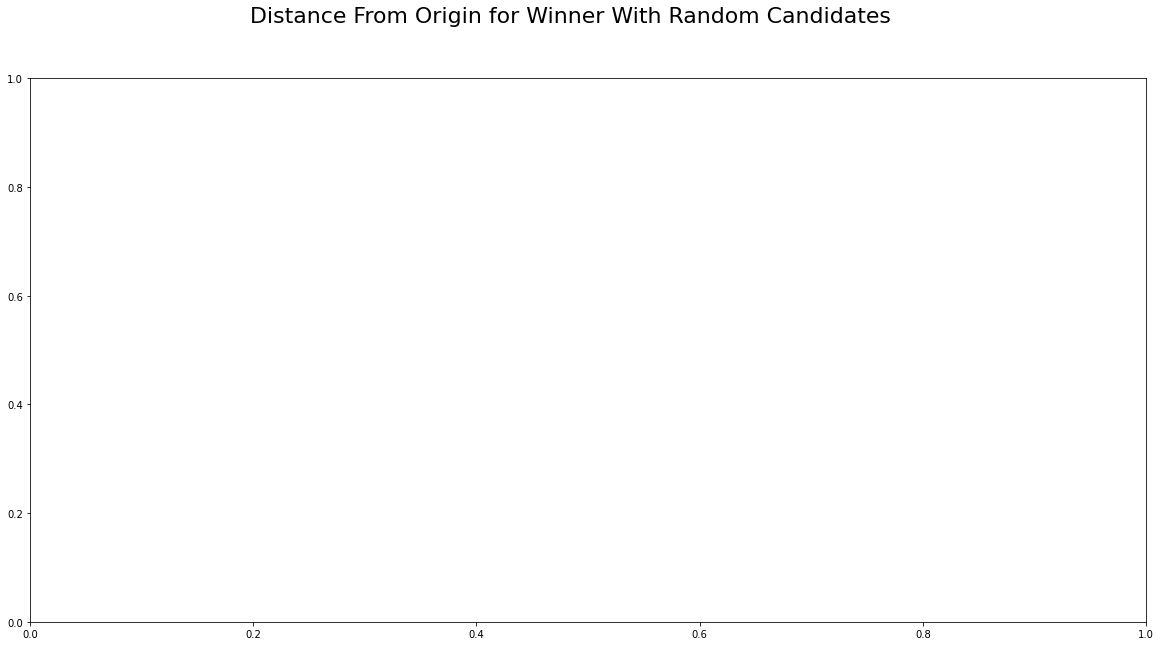

In [58]:
# print(winners)
# print(np.min(winners), np.max(winners))
plot_results([winners], ["irv-strategy"])

In [50]:
def foo():
    location=0
    scale=1
    ideology = np.random.normal(loc=location, scale=scale)
    ideology = np.array([ideology])
    print(f"np.random.normal returns {ideology}")
    print(np.random.normal(0, 1))